In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import networkx as nx
import EoN
import numpy as np

## Testing meaning of recovery_rate (gamma) parameter

Setting gamma=0.07 should mean that it takes infected people 14 days to recover.

In [27]:
gamma = 0.07
G = nx.fast_gnp_random_graph(1000, 1)
data = EoN.fast_SIR(G, 0, gamma, initial_infecteds=list(range(1000)), return_full_data=True)

# Run test
times_of_recovery = np.array([data.node_history(i)[0][1] for i in range(1000)])
np.mean(times_of_recovery)

14.591329562664948

We see that this is the case. Hence, gamma=(1/infectious period), as expected.

## Testing meaning of transmission_rate (tau) parameter

To test that the transmission rate is indeed the transmission rate specified in the textbook (which denotes it by $\beta$). Our experiment is as follows: We run have a network of 2 nodes, one infected, one susceptible. If the transmission_rate parameter is indeed transmission rate, the tranmission probability (the probability that the infected node will infect the susceptible node before it recovers) is given by the formula: $1-e^{-tranmissionRate*infectiousPeriod}$ 

Plugging in 0.03 for tranmission rate 14 for infectious period yields a transmission probability of 0.34. We run our experiment many times to check if the infected node infects the susceptible node 0.34 of the time.

In [77]:
# Parameters
beta = 0.03  # transmission rate
gamma = 1/14 # recovery rate, which averages recovery to 14 days
trials = 100000

In [78]:
# Analytic prediction of tranmission probability
infectious_period = 1/gamma
1 - np.exp(-beta*infectious_period)

0.34295318018494325

In [79]:
%%time
G = nx.fast_gnp_random_graph(2, 1)

times_virus_was_transmitted = 0
for i in range(trials):
    # Run simulation
    t, S, I, R = EoN.fast_SIR(G, beta, gamma, initial_infecteds=0)

    # If 2 recovered at end, then virus was transmitted
    if R[-1] == 2:  
        times_virus_was_transmitted += 1

times_virus_was_transmitted / trials  # Percentage of trials in which the virus was transmitted

Wall time: 5.63 s


0.29626

Well, 0.295 is not 0.34. Further experiments show that, as the infectious period increases (i.e. gamma decreases), the analytic prediction and the experimental results become more and more distant.

## Experiments in trying to estimate R0
**NOTE**: Using a star graph rather than the G(n, p) graph our simulation simplifies the problem a bit. In the G(n, p) model, some infected nodes may both be connected to the same susceptible nodes, and thus, if one infected node infected the susceptible node, the other infected node would not be able to, and thus would have less than the average of 60 susceptible nodes that it is in contact with.

Wall time: 7.42 s


18.5803

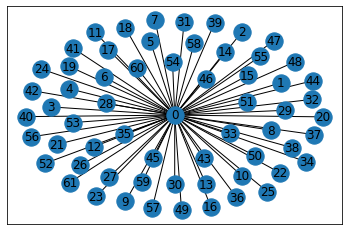

In [83]:
%%time
# Parameters
nodes = 61
transmission_rate = 0.03
gamma = 0.07
trials = 10000

# Build star graph (we will infect center node and all outer nodes will be susceptible)
G = nx.star_graph(nodes)
nx.draw_networkx(G)

# Run experiment 'trials' times
total_infected = 0
for i in range(trials):
    # Begin with only center node infected
    t, S, I, R = EoN.fast_SIR(G, transmission_rate, gamma, initial_infecteds=0)
    
    # Everyone who recovers was infected by initial infection, except initial infection themselves
    total_infected += R[-1] - 1  
    
# Print average number of infections caused by 1 initial infection -- aka R0
total_infected/trials 

## Exploring .transmissions() member function -- might be able to use to calculate R0

In [80]:
G = nx.fast_gnp_random_graph(10, 0.5)
data = EoN.fast_SIR(G, 0.5, gamma, initial_infecteds=0, return_full_data=True)
data.transmissions()

[(0, None, 0),
 (0.9053544823714558, 0, 4),
 (1.236912815343973, 4, 1),
 (1.3277261777692466, 1, 3),
 (1.3320550632425379, 1, 2),
 (1.3445622709096783, 0, 7),
 (1.4405491472383503, 3, 8),
 (1.4530554084418508, 3, 5),
 (2.3798921884243915, 1, 9),
 (4.72860324206877, 3, 6)]